In [1]:
import pandas as pd
import random
import time
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
import joblib


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [2]:
random.seed(90)
mushroom = fetch_ucirepo(id=73) 
  
X = mushroom.data.features 
y = mushroom.data.targets 

df = pd.DataFrame(X)
df = df.drop(columns=['veil-type'])
df["target"] = y
df = df.apply(LabelEncoder().fit_transform)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1], df["target"], test_size=0.2, random_state=42)


### GridSearch 

In [ ]:
model_classes = [
    ('KNN', KNeighborsClassifier(), {
        'n_neighbors': list(range(3, 21)), 
        'weights': ['uniform', 'distance'], 
        'p': [1, 2]  
    }),

    ('DecisionTree', DecisionTreeClassifier(), {
        'max_depth': [None, 5, 10, 15, 20],  
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 5],  
        'criterion': ['gini', 'entropy'],  
        'max_features': [None, 'sqrt', 'log2'] 
    }),

    ('RandomForest', RandomForestClassifier(), {
        'n_estimators': [10, 25, 50, 100, 150, 200],  
        'max_depth': [None, 10, 20],  
        'min_samples_split': [2, 5, 10],  
        'min_samples_leaf': [1, 2, 4],  
        'max_features': ['sqrt', 'log2', None],
        'random_state':42
    }),

    ('Logistic regression', LogisticRegression(), {
        'penalty': ['l1', 'l2', 'elasticnet', None], 
        'C': [0.01, 0.1, 0.5, 1, 10, 100],            
        'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'], 
        'max_iter': [50, 100, 150, 200, 250, 300, 250, 400, 450, 500]
    })
    ,
    ('SVM', SVC(), {
        'C': [0.1, 1, 10], 
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto'], 
        'degree': [2, 3, 4]
    }),
    
    ('AdaBoost', AdaBoostClassifier(), {
        'n_estimators': [50, 75, 100, 125, 150, 175, 200],
        'learning_rate': [0.01, 0.05, 0.1, 1.0]
    }),

    ('NaiveBayes', GaussianNB(), {
    })
]

In [5]:
def sim_grid(X_train, X_test, y_train, y_test, prefix=None):
    if prefix==None:
        prefix = ""
        
    results = []
    best = []

    for name, model, param_grid in model_classes:
        print(f"{name} - tuning...")

        grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        start_time = time.time()

        grid.fit(X_train, y_train)
        end_time = time.time()
        elapsed_time = end_time - start_time
        best_model = grid.best_estimator_
        joblib.dump(best_model, f"models/{prefix}_{name}_best_model.pkl")
        preds = best_model.predict(X_test)
        acc = accuracy_score(y_test, preds)

        #print(f"{name} - Best Params: {grid.best_params_}")
        #print(f"{name} - Test Accuracy: {acc:.4f}")
        #print(f"Training time: {elapsed_time:.2f} seconds")


        
        #print(classification_report(y_test, preds))

        conf_matrix = confusion_matrix(y_test, preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["E", "P"], yticklabels=["E", "P"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.savefig(f"results\{prefix}_matrix_{name}.png") 
        #plt.show()


        results.append((name, acc))
        best.append((name, grid.best_params_))

        results_df = pd.DataFrame(grid.cv_results_)
        results_df = pd.DataFrame(grid.cv_results_)
        param_cols = [col for col in results_df.columns if col.startswith('param_')]
        results_df = results_df[param_cols + ['mean_test_score', 'mean_fit_time', 'rank_test_score']]
        results_df.to_csv(f"grid_results/{prefix}_{name}.csv")

    for name, acc in results:
        print(f"{name}: {acc:.4f}")

    return best

<string>:35: SyntaxWarning: invalid escape sequence '\{'
<>:35: SyntaxWarning: invalid escape sequence '\{'
<string>:35: SyntaxWarning: invalid escape sequence '\{'
<>:35: SyntaxWarning: invalid escape sequence '\{'
C:\Users\olahe\AppData\Local\Temp\ipykernel_4416\2211716275.py:35: SyntaxWarning: invalid escape sequence '\{'
  plt.savefig(f"results\{prefix}_matrix_{name}.png")


In [6]:
from sklearn.metrics import roc_curve, auc

def sim_nn(X_train, X_test, y_train, y_test, prefix=None):

    if prefix==None:
        prefix = ""

    model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation="sigmoid")
])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping]
    )

    joblib.dump(model, f"models/{prefix}_nn_best_model.pkl")


    y_pred = (model.predict(X_test) > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    #print(f"Dokładność: {acc:.2f}")
    #print("Raport klasyfikacji:")


    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["E", "P"], yticklabels=["E", "P"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"results\{prefix}_matrix_nn.png") 
    #plt.show()



    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Loss (training)")
    plt.plot(history.history["val_loss"], label="Loss (validation)")
    #plt.title("Loss During Training and Validation")
    plt.xlabel("Epoch", fontsize = 18)
    plt.ylabel("Loss", fontsize = 18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend()
    plt.savefig(f"results\{prefix}_loss_nn.png") 
    #plt.show()



    # Train vs Validation Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs', fontsize = 18)
    plt.ylabel('Accuracy', fontsize =18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend()
    plt.savefig(f"results\{prefix}_train_val_accuracy.png")
    plt.close()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize = 18)
    plt.ylabel('True Positive Rate', fontsize =18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    #plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.savefig(f"results\{prefix}_roc_curve.png")
    plt.close()

<string>:58: SyntaxWarning: invalid escape sequence '\{'
<string>:72: SyntaxWarning: invalid escape sequence '\{'
<string>:86: SyntaxWarning: invalid escape sequence '\{'
<string>:101: SyntaxWarning: invalid escape sequence '\{'
<>:58: SyntaxWarning: invalid escape sequence '\{'
<>:72: SyntaxWarning: invalid escape sequence '\{'
<>:86: SyntaxWarning: invalid escape sequence '\{'
<>:101: SyntaxWarning: invalid escape sequence '\{'
<string>:58: SyntaxWarning: invalid escape sequence '\{'
<string>:72: SyntaxWarning: invalid escape sequence '\{'
<string>:86: SyntaxWarning: invalid escape sequence '\{'
<string>:101: SyntaxWarning: invalid escape sequence '\{'
<>:58: SyntaxWarning: invalid escape sequence '\{'
<>:72: SyntaxWarning: invalid escape sequence '\{'
<>:86: SyntaxWarning: invalid escape sequence '\{'
<>:101: SyntaxWarning: invalid escape sequence '\{'
C:\Users\olahe\AppData\Local\Temp\ipykernel_4416\1758586999.py:58: SyntaxWarning: invalid escape sequence '\{'
  plt.savefig(f"resul

In [12]:
sim_grid(X_train, X_test, y_train, y_test)


KNN - tuning...


C:\Users\olahe\AppData\Local\Temp\ipykernel_25024\2211716275.py:35: SyntaxWarning: invalid escape sequence '\{'
  plt.savefig(f"results\{prefix}_matrix_{name}.png")


KeyboardInterrupt: 

c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.6884 - loss: 0.5950 - val_accuracy: 0.9131 - val_loss: 0.2922
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8826 - loss: 0.3106 - val_accuracy: 0.9623 - val_loss: 0.1314
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9280 - loss: 0.2024 - val_accuracy: 0.9862 - val_loss: 0.0593
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9367 - loss: 0.1667 - val_accuracy: 0.9846 - val_loss: 0.0412
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9594 - loss: 0.1197 - val_accuracy: 0.9946 - val_loss: 0.0281
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9627 - loss: 0.1117 - val_accuracy: 0.9985 - val_loss: 0.0125
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9679 - loss: 0.0851 - val_accuracy: 0.9946 - val_loss: 0.0155
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9776 - loss: 0.0683 - val_accu

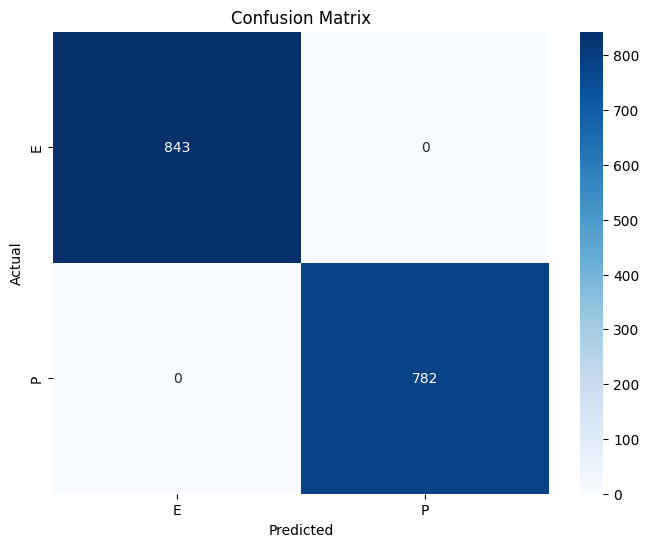

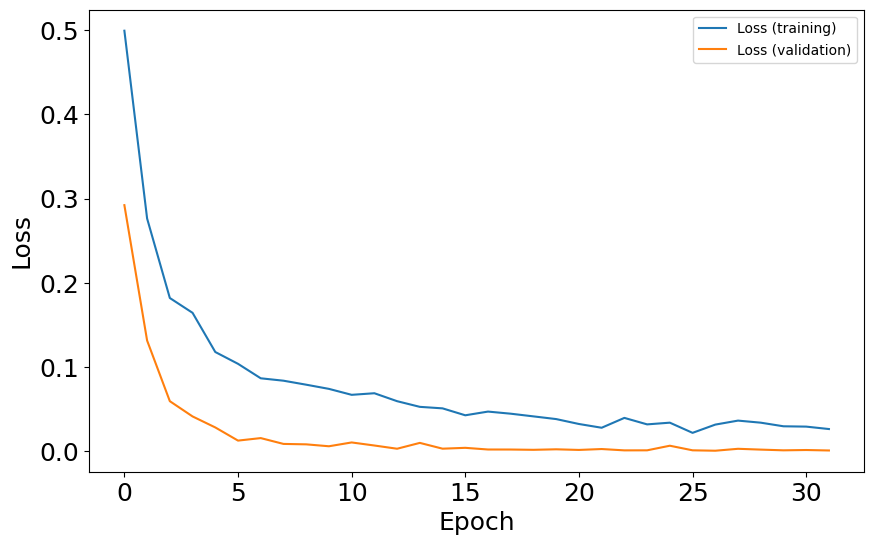

In [7]:
sim_nn(X_train, X_test, y_train, y_test)


### Feature Importance - Random forest 

C:\Users\olahe\AppData\Local\Temp\ipykernel_25024\3303807713.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[1] for x in feature_importances], y=[x[0] for x in feature_importances], palette='ch:s=.25,rot=-.25')


<Axes: >

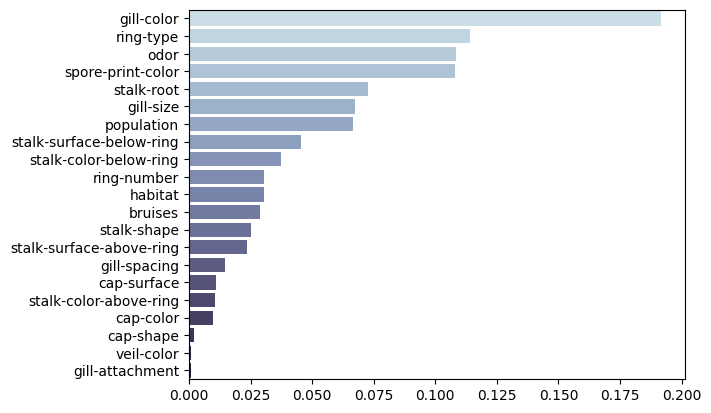

In [9]:
best_model = RandomForestClassifier(
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=10,
    random_state=42
)

best_model.fit(X_train, y_train)
importances = best_model.feature_importances_
feature_importances = sorted(zip(X_train, importances), key=lambda x: x[1], reverse=True)
sns.barplot(x=[x[1] for x in feature_importances], y=[x[0] for x in feature_importances], palette='ch:s=.25,rot=-.25')


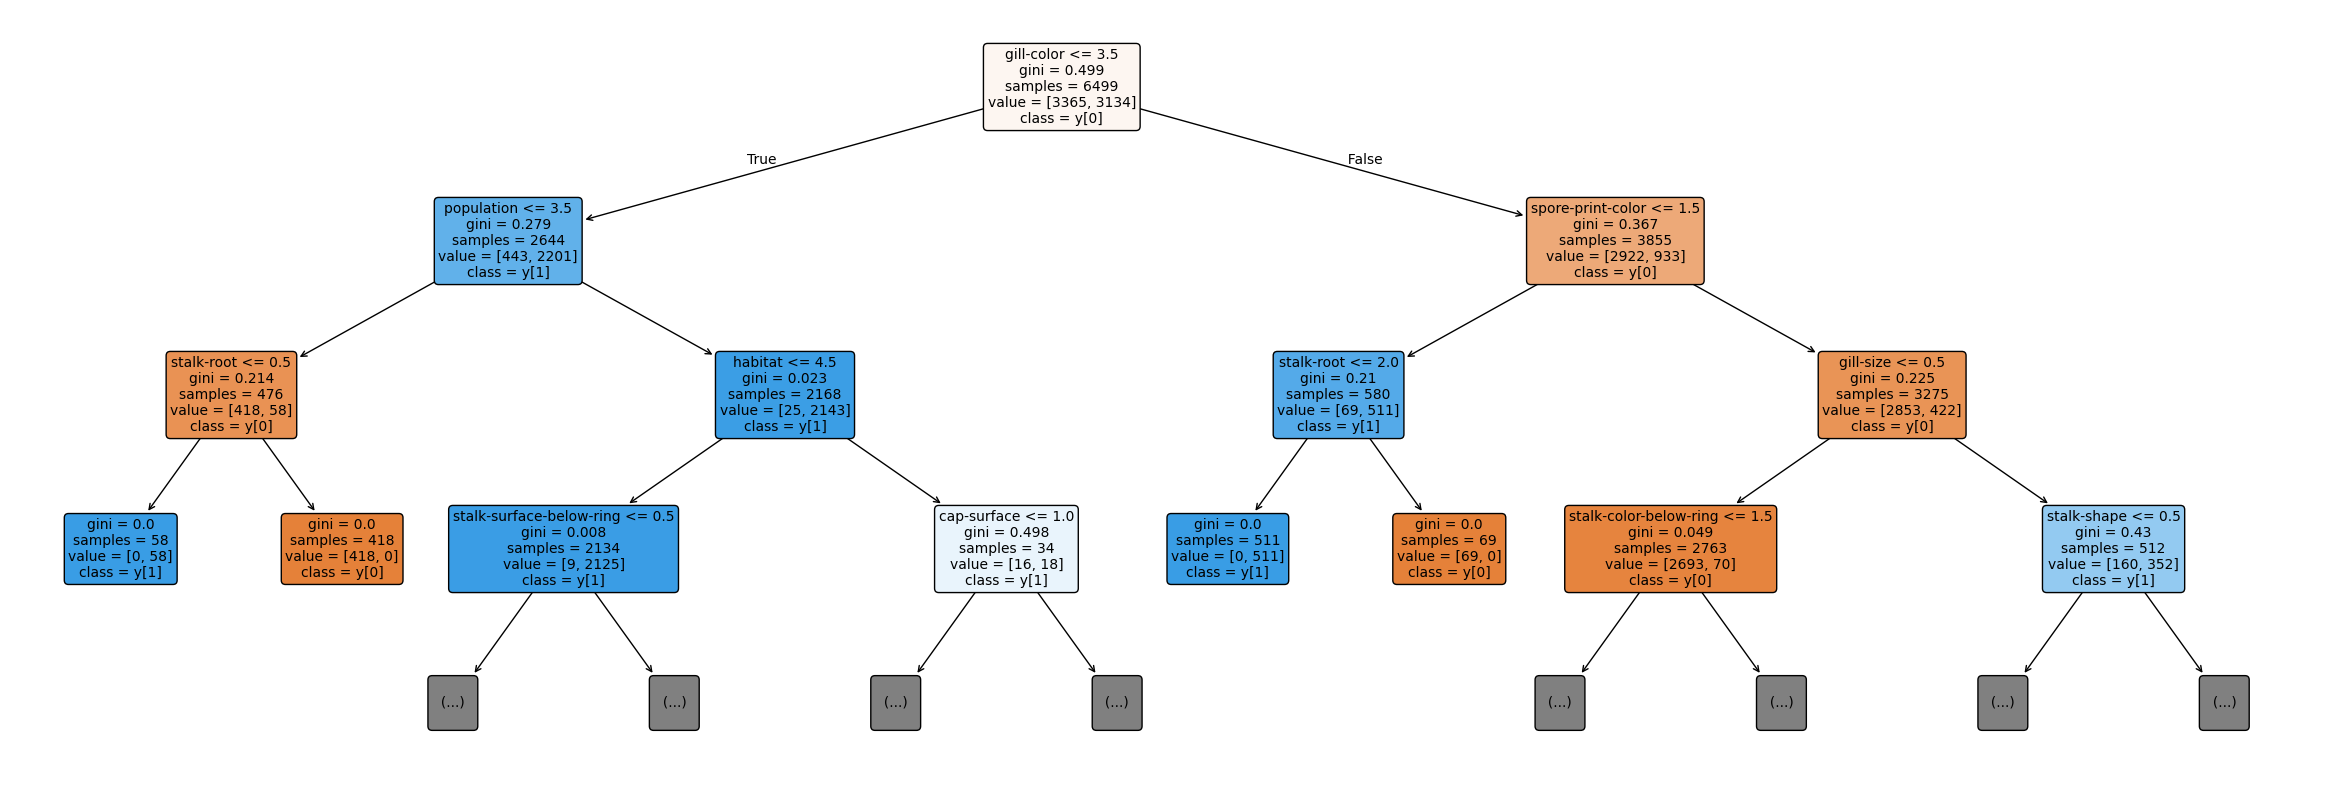

<>:13: SyntaxWarning: invalid escape sequence '\i'
<>:13: SyntaxWarning: invalid escape sequence '\i'
C:\Users\olahe\AppData\Local\Temp\ipykernel_25024\2960161660.py:13: SyntaxWarning: invalid escape sequence '\i'
  plt.savefig(f"results\importance.png")
C:\Users\olahe\AppData\Local\Temp\ipykernel_25024\2960161660.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[1] for x in feature_importances], y=[x[0] for x in feature_importances], palette='ch:s=.25,rot=-.25')


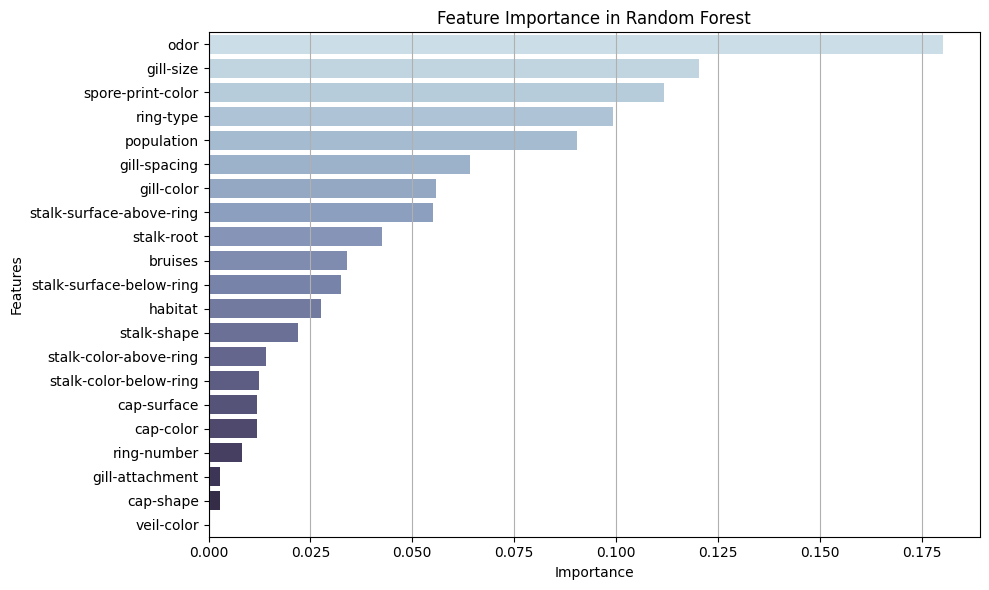

Feature Importance (sorted):
odor: 0.1803
gill-size: 0.1203
spore-print-color: 0.1118
ring-type: 0.0992
population: 0.0905
gill-spacing: 0.0642
gill-color: 0.0559
stalk-surface-above-ring: 0.0550
stalk-root: 0.0427
bruises: 0.0341
stalk-surface-below-ring: 0.0326
habitat: 0.0276
stalk-shape: 0.0219
stalk-color-above-ring: 0.0142
stalk-color-below-ring: 0.0124
cap-surface: 0.0119
cap-color: 0.0118
ring-number: 0.0083
gill-attachment: 0.0027
cap-shape: 0.0027
veil-color: 0.0000


In [10]:
model = joblib.load('models/_RandomForest_best_model.pkl')
importances = model.feature_importances_
feature_importances = sorted(zip(X_train, importances), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 6))
plt.grid()

sns.barplot(x=[x[1] for x in feature_importances], y=[x[0] for x in feature_importances], palette='ch:s=.25,rot=-.25')
plt.title("Feature Importance in Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout() 
plt.savefig(f"results\importance.png") 
plt.show()

print("Feature Importance (sorted):")
for feature, importance in feature_importances:
    print(f"{feature}: {importance:.4f}")

## Feature Selection

## 80%

C:\Users\olahe\AppData\Local\Temp\ipykernel_4416\2258931283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["target"] = df["target"]


KNN - tuning...
DecisionTree - tuning...
RandomForest - tuning...
Logistic regression - tuning...


c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2100 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\olahe\A

SVM - tuning...
AdaBoost - tuning...


c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


NaiveBayes - tuning...
KNN: 1.0000
DecisionTree: 1.0000
RandomForest: 1.0000
Logistic regression: 0.9489
SVM: 1.0000
AdaBoost: 1.0000
NaiveBayes: 0.9145


c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6876 - loss: 0.5902 - val_accuracy: 0.9246 - val_loss: 0.2854
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9003 - loss: 0.2756 - val_accuracy: 0.9623 - val_loss: 0.1042
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9308 - loss: 0.1897 - val_accuracy: 0.9846 - val_loss: 0.0587
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9548 - loss: 0.1291 - val_accuracy: 0.9838 - val_loss: 0.0469
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9590 - loss: 0.1112 - val_accuracy: 0.9923 - val_loss: 0.0229
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9708 - loss: 0.0898 - val_accuracy: 0.9954 - val_loss: 0.0139
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9692 - loss: 0.0913 - val_accuracy: 0.9954 - val_loss: 0.0094
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9787 - loss: 0.0716 - val_accuracy: 0.

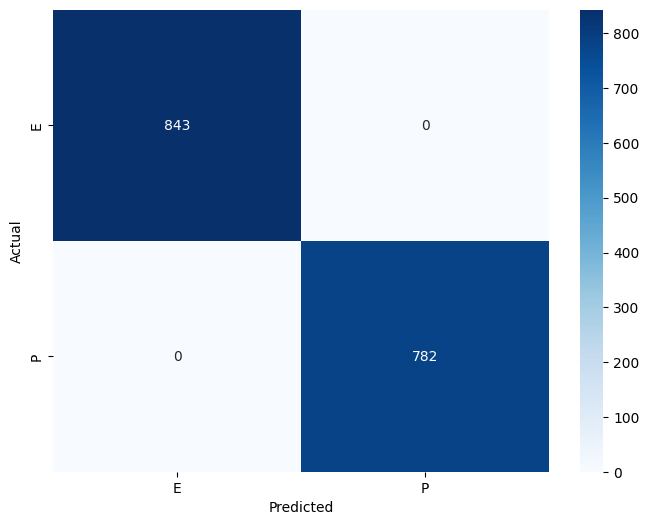

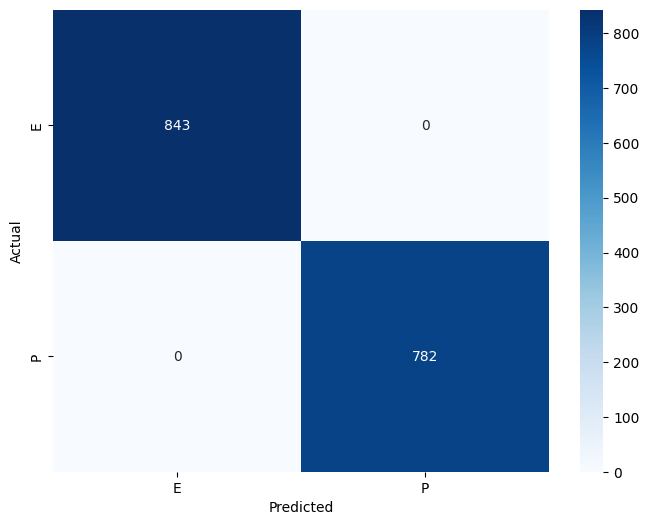

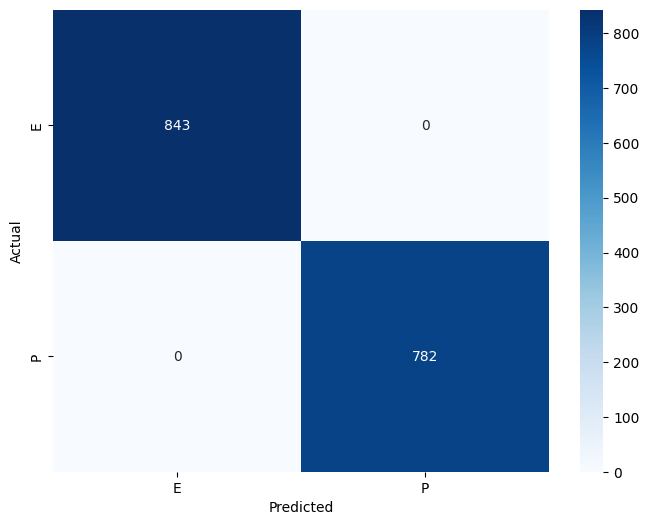

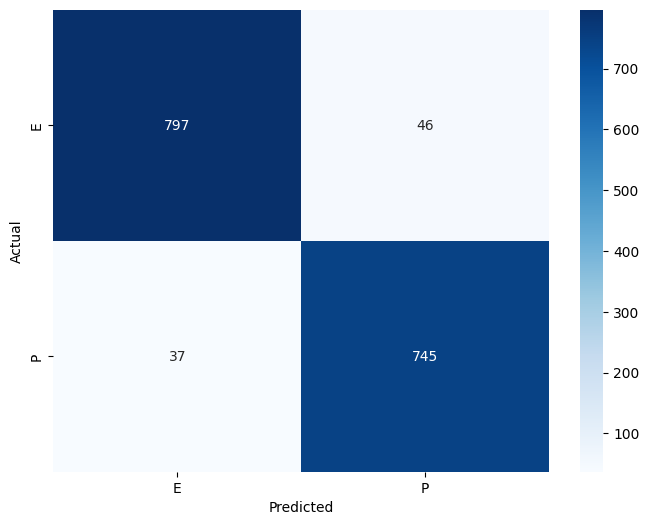

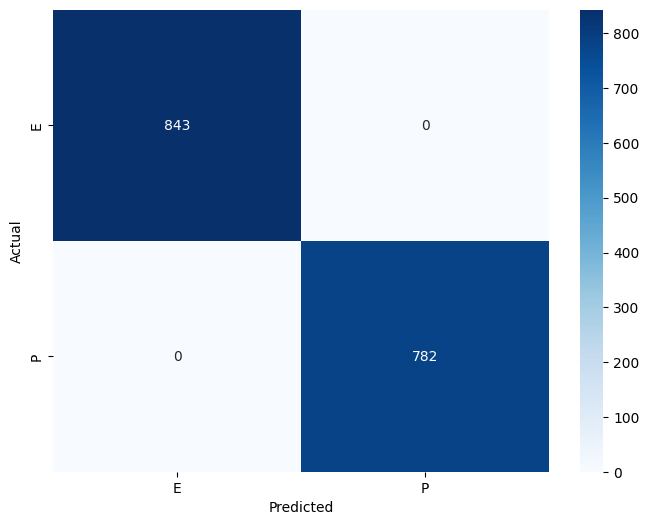

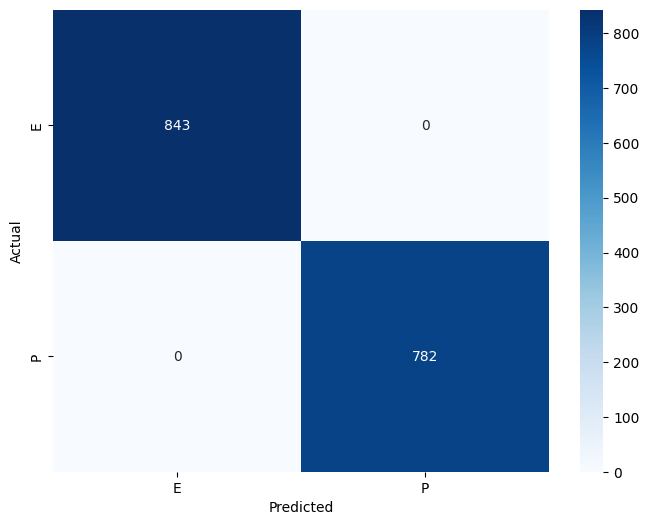

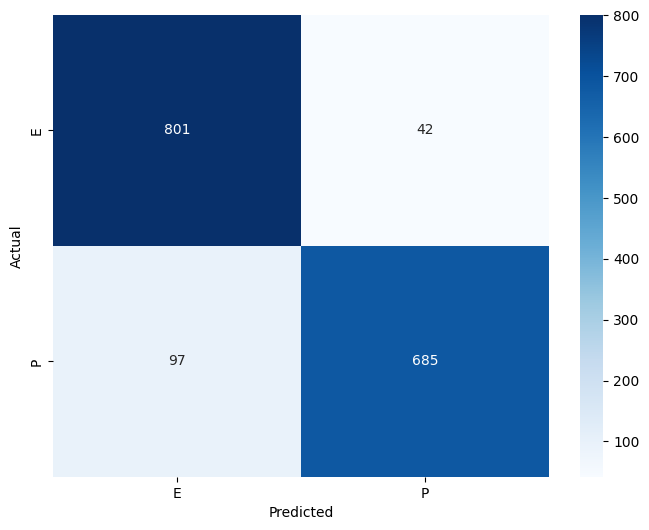

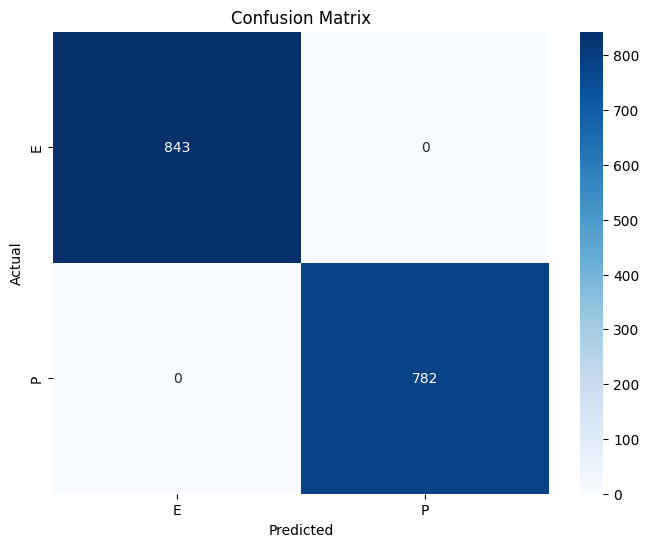

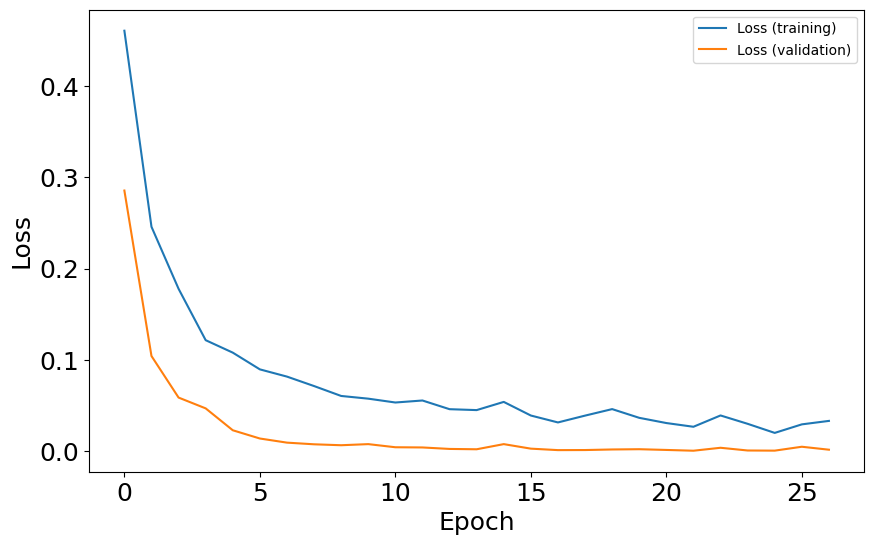

In [7]:
df2 = df[["gill-color", "gill-spacing", "odor", "ring-type",  "spore-print-color", "stalk-root", "gill-size", "population", "stalk-surface-below-ring" ,"bruises", 
          "stalk-surface-above-ring", "habitat"]] 
df2["target"] = df["target"]
X_train, X_test, y_train, y_test = train_test_split(df2.iloc[:, 0:-1], df2["target"], test_size=0.2, random_state=42)
sim_grid(X_train, X_test, y_train, y_test, "80")
sim_nn(X_train, X_test, y_train, y_test, "80")


## 70%

C:\Users\olahe\AppData\Local\Temp\ipykernel_37240\3301689025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["target"] = df["target"]


KNN - tuning...
DecisionTree - tuning...
RandomForest - tuning...
Logistic regression - tuning...


c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1050 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\olahe\A

SVM - tuning...
AdaBoost - tuning...


c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


NaiveBayes - tuning...
KNN: 1.0000
DecisionTree: 1.0000
RandomForest: 1.0000
Logistic regression: 0.8935
SVM: 1.0000
AdaBoost: 1.0000
NaiveBayes: 0.8289


c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7324 - loss: 0.5563 - val_accuracy: 0.9192 - val_loss: 0.2667
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9055 - loss: 0.2591 - val_accuracy: 0.9431 - val_loss: 0.1062
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9278 - loss: 0.1857 - val_accuracy: 0.9762 - val_loss: 0.0743
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9389 - loss: 0.1426 - val_accuracy: 0.9777 - val_loss: 0.0549
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9479 - loss: 0.1338 - val_accuracy: 0.9754 - val_loss: 0.0463
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9570 - loss: 0.1123 - val_accuracy: 0.9877 - val_loss: 0.0427
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9616 - loss: 0.0979 - val_accuracy: 0.9900 - val_loss: 0.0358
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9668 - loss: 0.0831 - val_accuracy: 0.

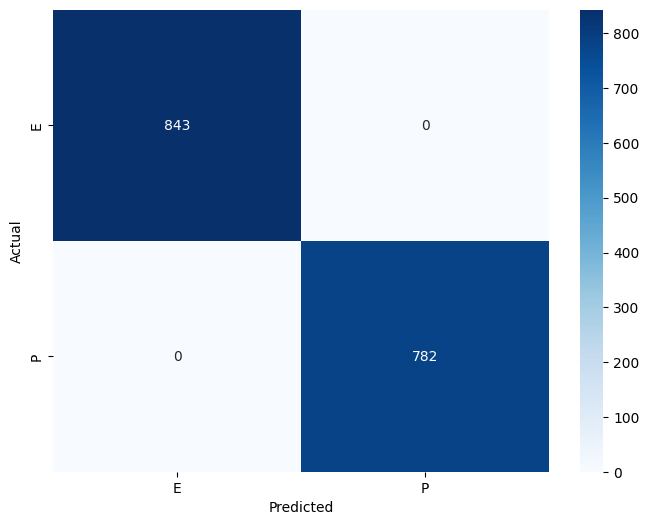

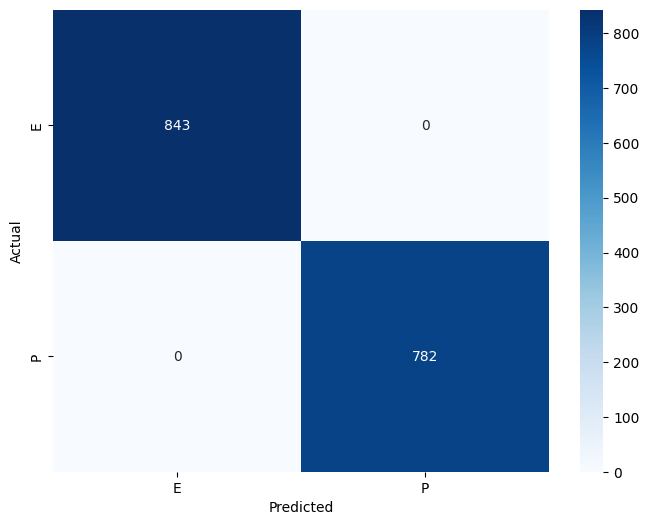

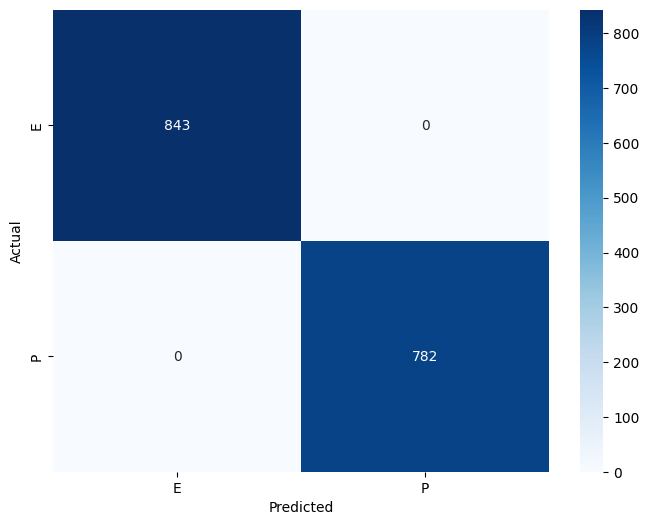

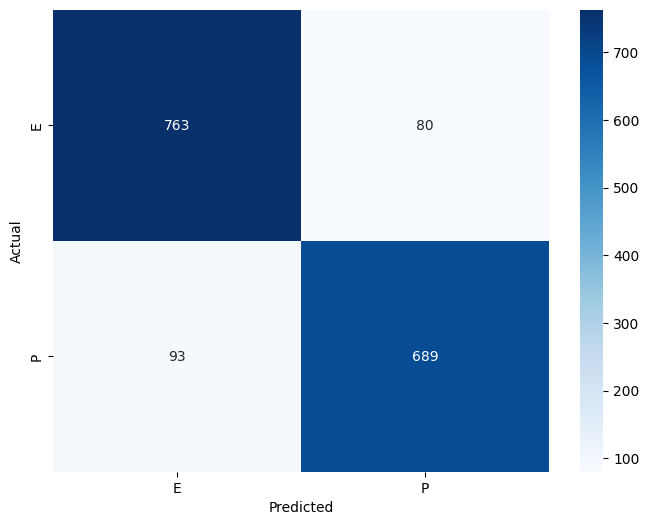

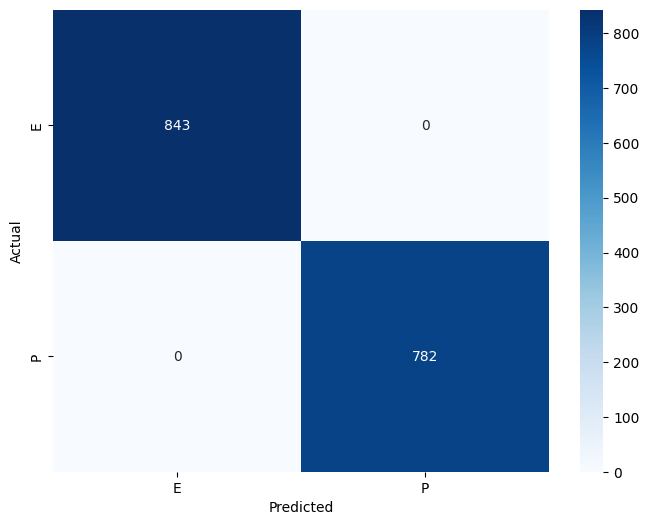

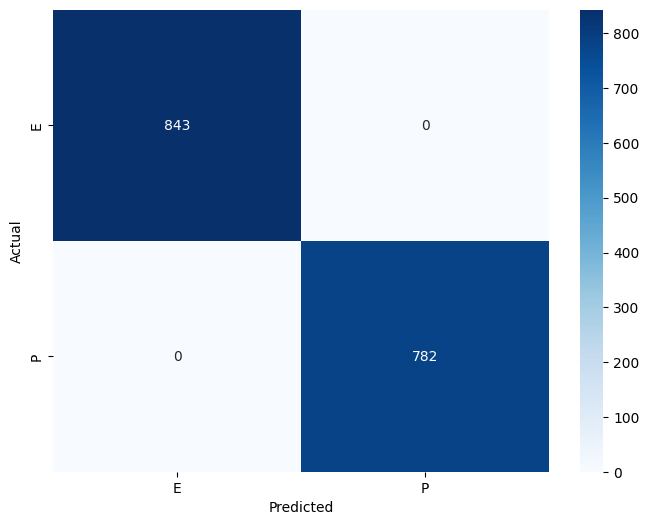

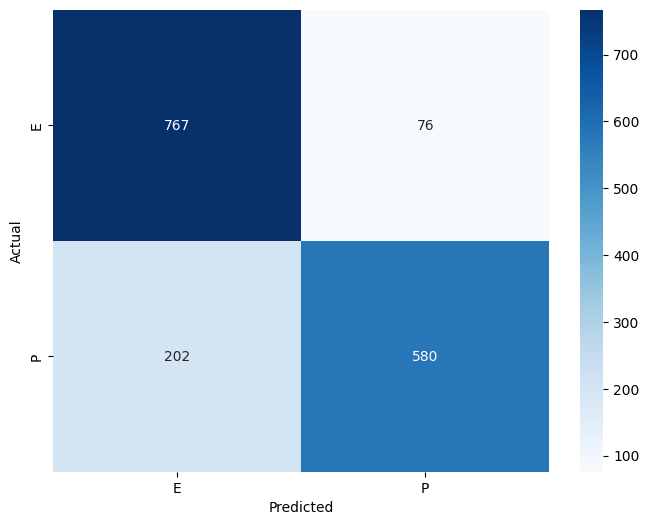

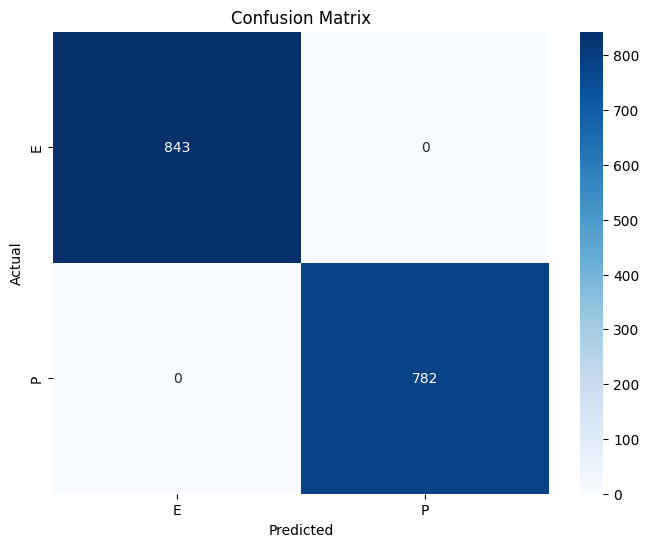

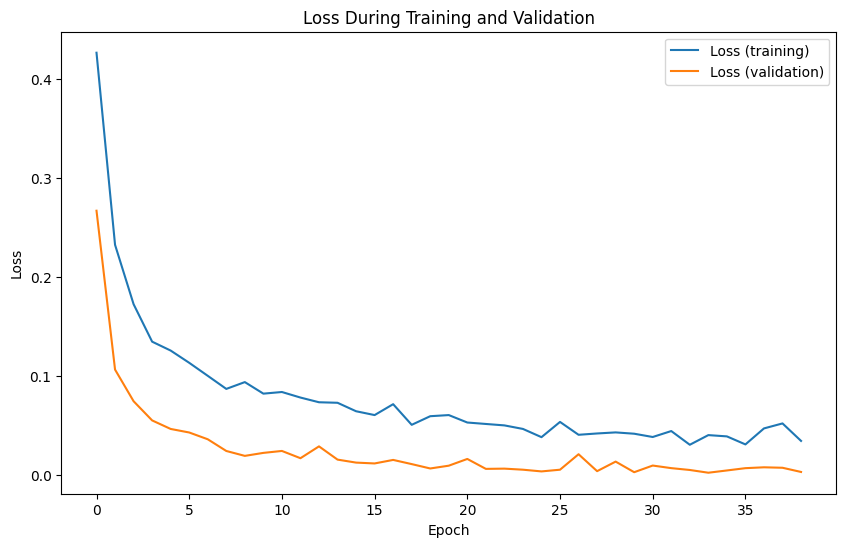

In [29]:
df4 = df[["gill-color", "odor", "ring-type",  "spore-print-color", "stalk-root", "gill-size", "population"]] 
df4["target"] = df["target"]
X_train, X_test, y_train, y_test = train_test_split(df4.iloc[:, 0:-1], df4["target"], test_size=0.2, random_state=42)
sim_grid(X_train, X_test, y_train, y_test, "70")
sim_nn(X_train, X_test, y_train, y_test, "70")


## 60%

C:\Users\olahe\AppData\Local\Temp\ipykernel_4416\3686999010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["target"] = df["target"]


KNN - tuning...
DecisionTree - tuning...
RandomForest - tuning...


c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Logistic regression - tuning...


c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2100 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\olahe\A

SVM - tuning...
AdaBoost - tuning...


c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


NaiveBayes - tuning...
KNN: 1.0000
DecisionTree: 1.0000
RandomForest: 1.0000
Logistic regression: 0.8677
SVM: 1.0000
AdaBoost: 0.9932
NaiveBayes: 0.7834
Epoch 1/50


c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 1618s 16ms/step - accuracy: 0.7342 - loss: 0.5466 - val_accuracy: 0.8415 - val_loss: 0.3560
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8873 - loss: 0.3105 - val_accuracy: 0.9215 - val_loss: 0.1671
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9230 - loss: 0.2150 - val_accuracy: 0.9746 - val_loss: 0.0787
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9382 - loss: 0.1775 - val_accuracy: 0.9815 - val_loss: 0.0555
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9483 - loss: 0.1476 - val_accuracy: 0.9838 - val_loss: 0.0399
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9618 - loss: 0.1242 - val_accuracy: 0.9754 - val_loss: 0.0472
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9545 - loss: 0.1291 - val_accuracy: 0.9838 - val_loss: 0.0319
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9731 - loss: 0.0888 - val_accuracy: 0.9838 -

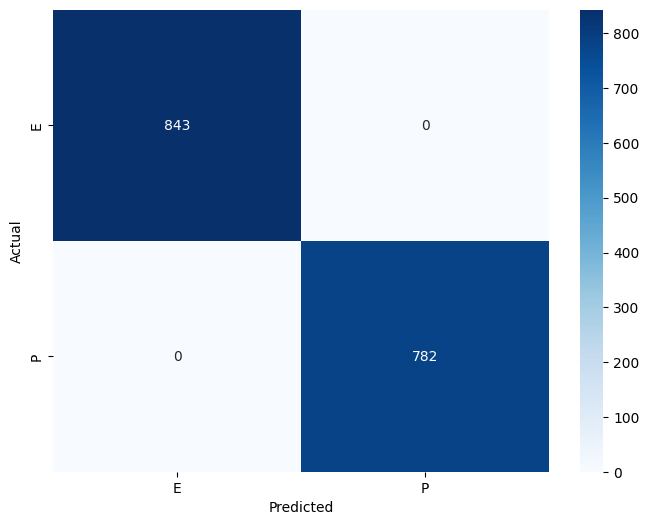

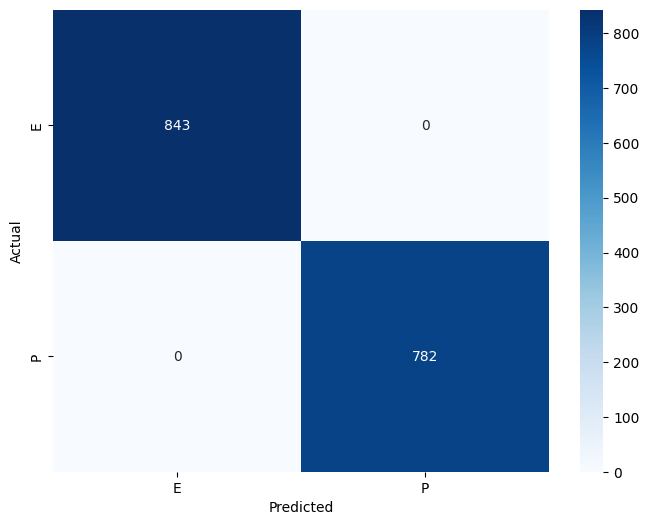

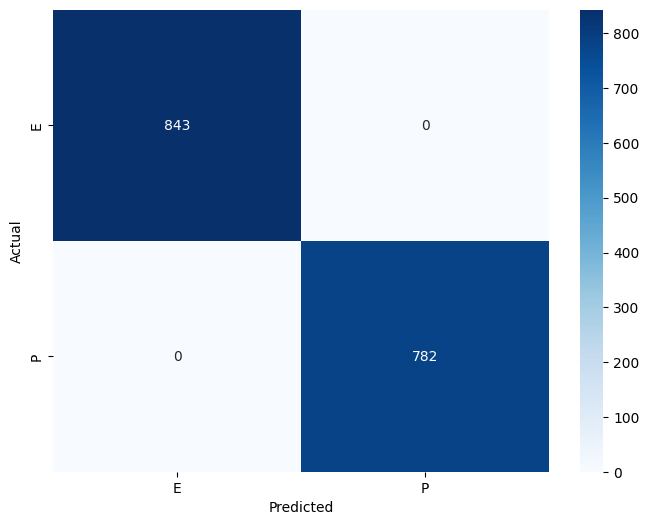

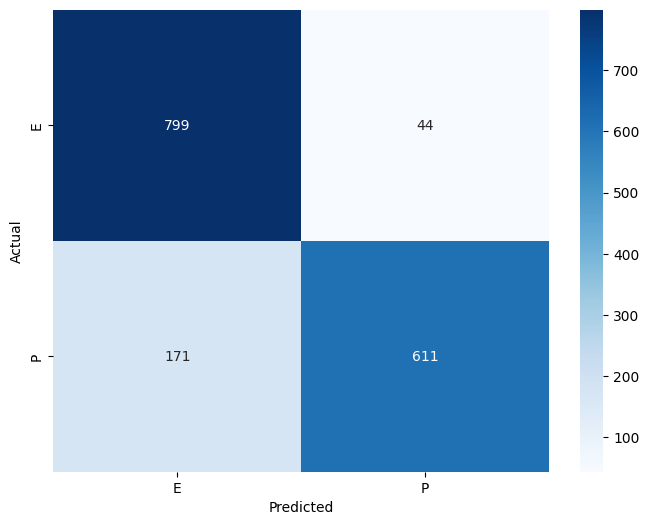

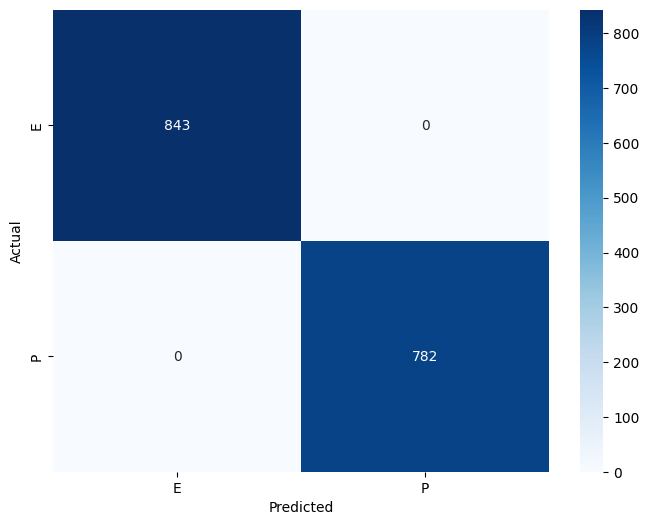

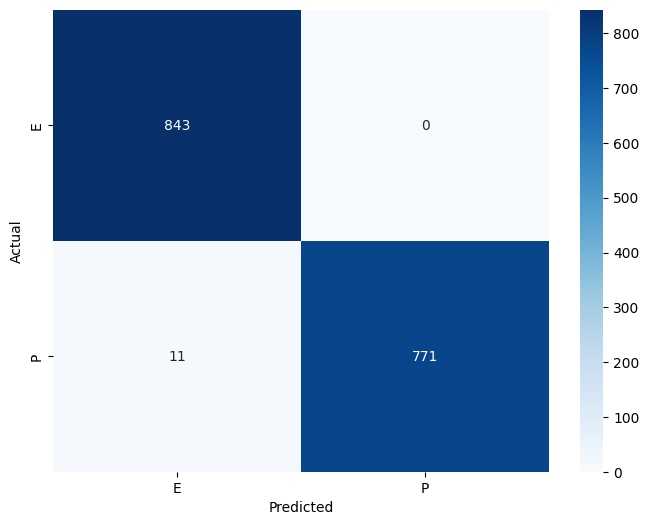

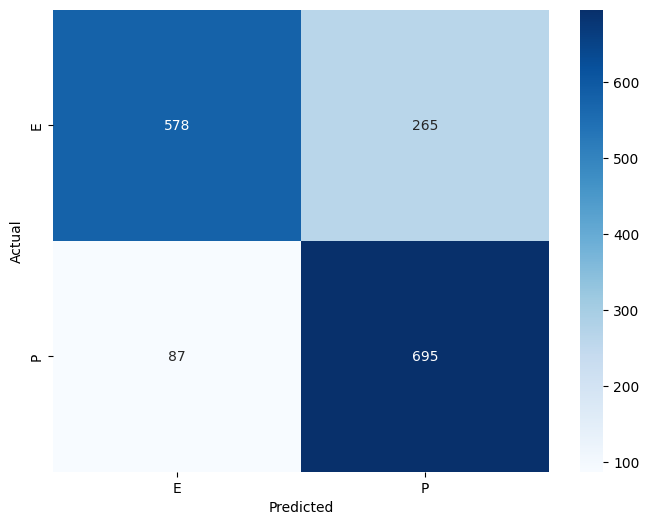

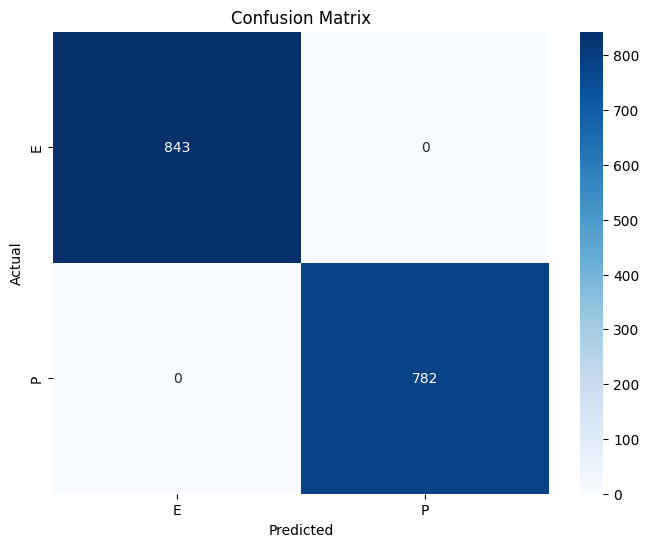

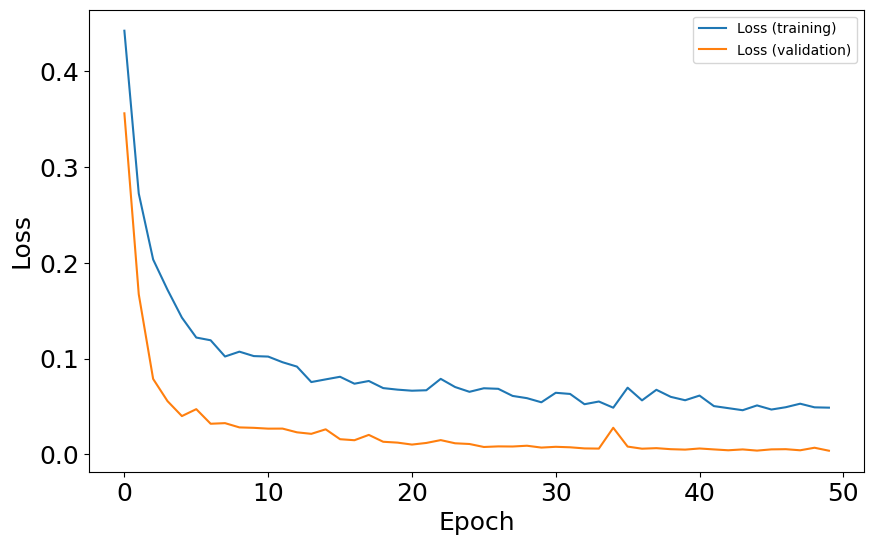

In [11]:
df3 = df[["gill-spacing", "odor", "ring-type", "population", "spore-print-color"]] #gill_color wywalone
df3["target"] = df["target"]
X_train, X_test, y_train, y_test = train_test_split(df3.iloc[:, 0:-1], df3["target"], test_size=0.2, random_state=42)
sim_grid(X_train, X_test, y_train, y_test, "57")
sim_nn(X_train, X_test, y_train, y_test, "57")


## 50%

C:\Users\olahe\AppData\Local\Temp\ipykernel_4416\533169076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["target"] = df["target"]


KNN - tuning...


c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


DecisionTree - tuning...
RandomForest - tuning...
Logistic regression - tuning...


c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2100 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\olahe\A

SVM - tuning...
AdaBoost - tuning...


c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


NaiveBayes - tuning...
KNN: 0.9926
DecisionTree: 0.9938
RandomForest: 0.9938
Logistic regression: 0.8837
SVM: 0.9932
AdaBoost: 0.9938
NaiveBayes: 0.7243


c:\Users\olahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6649 - loss: 0.6332 - val_accuracy: 0.8877 - val_loss: 0.3263
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8904 - loss: 0.2841 - val_accuracy: 0.9723 - val_loss: 0.1414
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9349 - loss: 0.1949 - val_accuracy: 0.9669 - val_loss: 0.0917
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9406 - loss: 0.1685 - val_accuracy: 0.9669 - val_loss: 0.0791
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9501 - loss: 0.1559 - val_accuracy: 0.9723 - val_loss: 0.0665
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9602 - loss: 0.1304 - val_accuracy: 0.9669 - val_loss: 0.0599
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9598 - loss: 0.1269 - val_accuracy: 0.9746 - val_loss: 0.0561
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9627 - loss: 0.1171 - val_accuracy: 

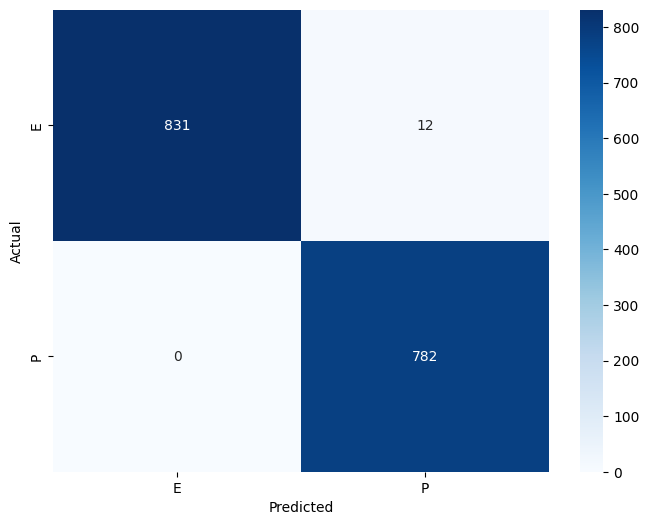

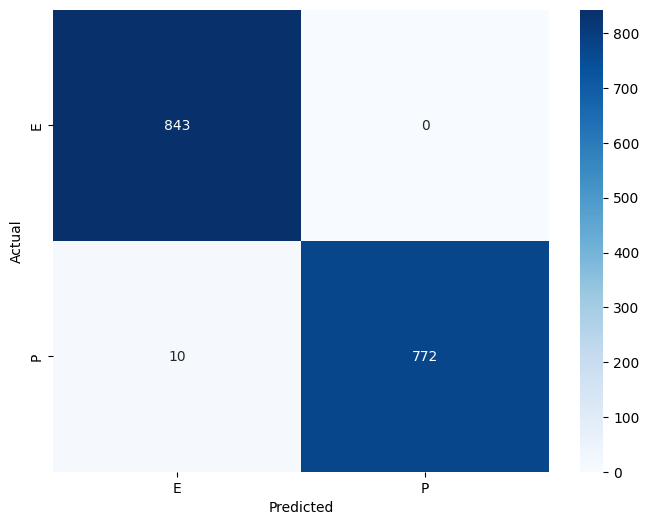

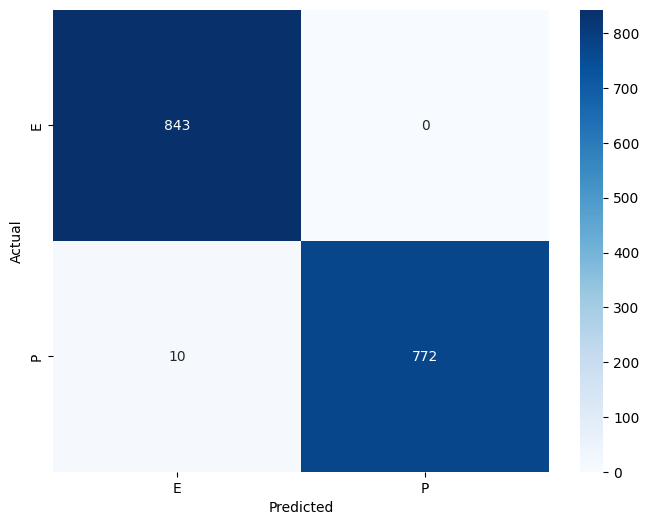

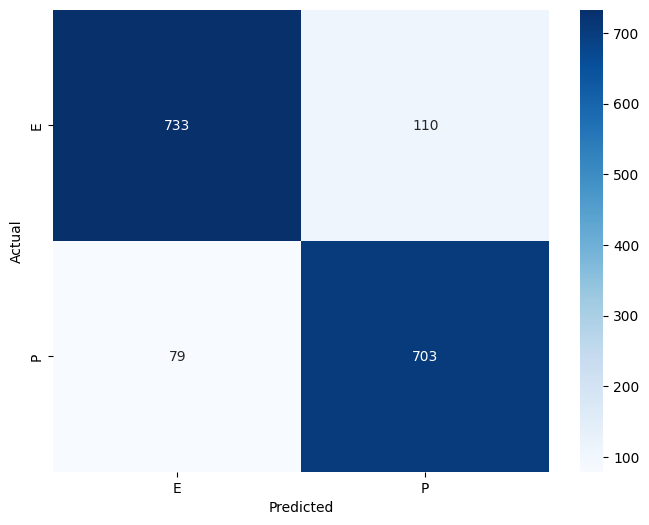

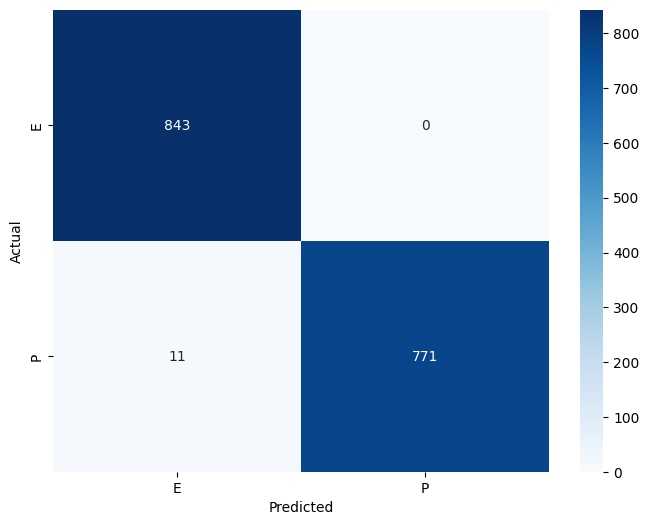

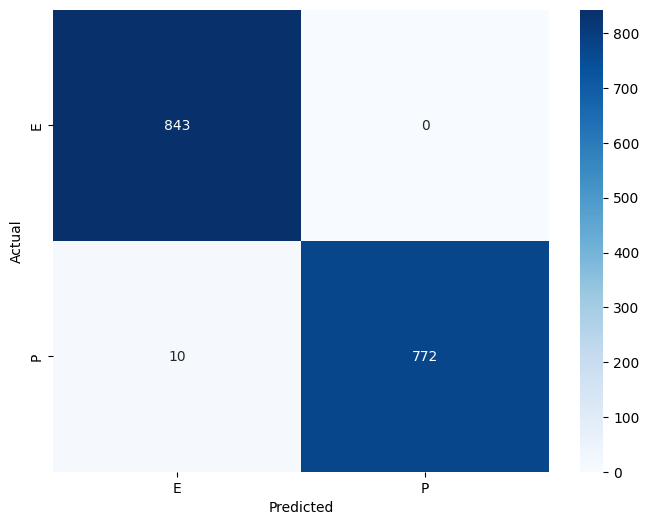

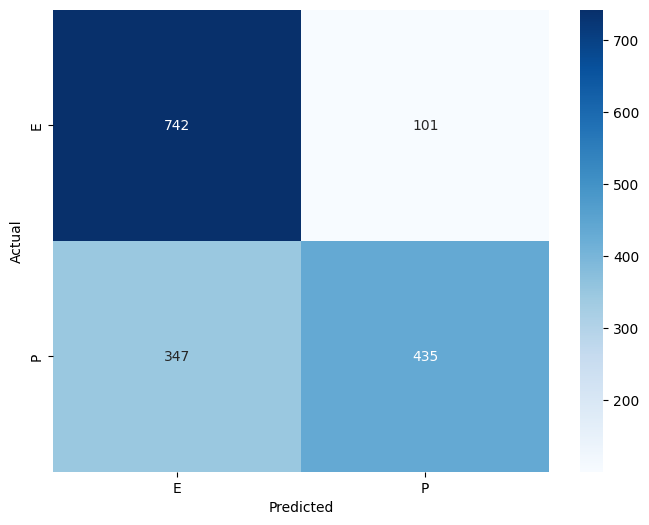

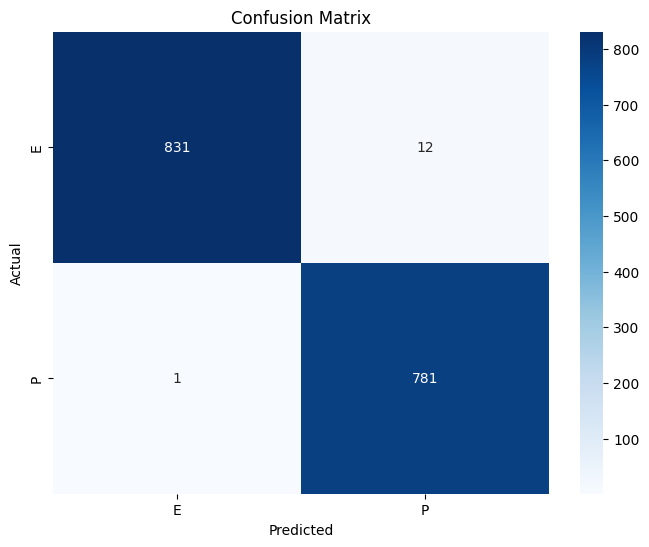

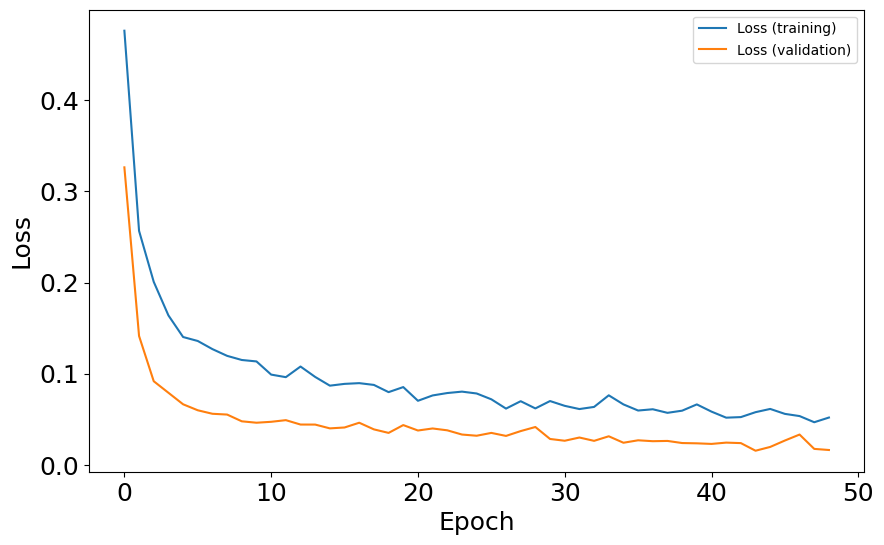

In [12]:
df3 = df[["gill-size", "odor", "ring-type",  "spore-print-color"]]
df3["target"] = df["target"]
X_train, X_test, y_train, y_test = train_test_split(df3.iloc[:, 0:-1], df3["target"], test_size=0.2, random_state=42)
sim_grid(X_train, X_test, y_train, y_test, "50")
sim_nn(X_train, X_test, y_train, y_test, "50")
